## 1. Преобразование чистых текстовых данных в структурированные (csv-формат)

In [1]:
import os
import re
from datetime import date

In [2]:

def combine_csv_files(folder_path: str):
    """
    Объединяет все CSV-файлы в указанной папке в один DataFrame
    и сохраняет результат в новый CSV-файл.
    Имя файла формата "<первый>-<последний>.csv".
    """
    # Получаем список CSV файлов в папке
    files = sorted([
        f for f in os.listdir(folder_path)
        if f.endswith('.csv') and '-' not in f
    ])
    if not files:
        raise FileNotFoundError("В указанной папке нет CSV-файлов.")

    # Имя итогового файла
    first_file = os.path.splitext(files[0])[0]
    last_file = os.path.splitext(files[-1])[0]
    output_name = f"{first_file}-{last_file}.csv"
    output_path = os.path.join(folder_path, output_name)

    # Читаем и объединяем
    dataframes = []
    for file in files:
        path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(path)
            dataframes.append(df)
        except Exception as e:
            print(f"⚠️ Ошибка при чтении {file}: {e}")

    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_csv(output_path, index=False, encoding='utf-8-sig')

    print(f"\n📁 Итоговый файл сохранён, Общее количество строк: {len(combined_df)}")

    return combined_df


df = combine_csv_files('./events/2_struct')
print(f'Размер банка событий: {len(df)}')


📁 Итоговый файл сохранён, Общее количество строк: 5651
Размер банка событий: 5651


In [3]:

# Месяцы в родительном падеже
MONTHS = {
    "января": 1, "февраля": 2, "марта": 3, "апреля": 4, "мая": 5, "июня": 6,
    "июля": 7, "августа": 8, "сентября": 9, "октября": 10, "ноября": 11, "декабря": 12,
}
MONTH_RE = r"(января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)"
DASH_RE = r"[—–-]"  # эм-, эн-, дефис

# Паттерны: сначала «день месяц — день месяц», затем «день—день месяц», затем одиночная дата
PATTERN_CROSS_MONTH = re.compile(
    rf"^(\d{{1,2}})\s+{MONTH_RE}\s*{DASH_RE}\s*(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)
PATTERN_SAME_MONTH_RANGE = re.compile(
    rf"^(\d{{1,2}})\s*{DASH_RE}\s*(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)
PATTERN_SINGLE_DATE = re.compile(
    rf"^(\d{{1,2}})\s+{MONTH_RE}\b",
    re.IGNORECASE,
)


def _month_num(name: str) -> int:
    return MONTHS[name.lower()]


def parse_events_file(source_path: str, out_path: str):
    # Год из имени файла (например, "2001.txt" → "2001")
    m_year = re.search(r"(\d{4})", os.path.basename(source_path))
    if m_year:
        year = int(m_year.group(1))
    else:
        print(f"⚠️ Не удалось распознать год из названия файла: {source_path}")
        return

    with open(source_path, "r", encoding="utf-8") as f:
        text = f.read()

    # По строкам, без пустых
    lines = [line.strip() for line in text.splitlines() if line.strip()]

    data = []
    current_start = None
    current_end = None

    for line in lines:
        # 1) Диапазон с разными месяцами: «25 июля—23 сентября …»
        m = PATTERN_CROSS_MONTH.match(line)
        if m:
            d1, m1, d2, m2 = m.groups()
            y_start = year
            y_end = year
            # если переход через год (например, «декабря—января») — увеличим год конца
            if _month_num(m2) < _month_num(m1) and year:
                # конец в следующем календарном году
                y_end = y_start + 1

            current_start = date(y_start, _month_num(m1), int(d1))
            current_end = date(y_end, _month_num(m2), int(d2))
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end, event))
            continue

        # 2) Диапазон в одном месяце: «1–30 января …»
        m = PATTERN_SAME_MONTH_RANGE.match(line)
        if m:
            d1, d2, m1 = m.groups()
            current_start = date(int(year), _month_num(m1), int(d1))
            current_end = date(int(year), _month_num(m1), int(d2))
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end, event))
            continue

        # 3) Одиночная дата: «2 января …» или «2 января:» (без события на той же строке)
        m = PATTERN_SINGLE_DATE.match(line)
        if m:
            d1, m1 = m.groups()
            current_start = date(int(year), _month_num(m1), int(d1))
            current_end = None
            event = line[m.end():].lstrip(" \t:—–-—").strip()
            if event:
                data.append((current_start, current_end or "", event.capitalize()))
            continue

        # 4) Строка-событие под текущей датой/диапазоном
        if current_start:
            data.append((current_start, current_end or "", line))
        else:
            print(f"⚠️ Не удалось распарсить строку: {line}")

    df = pd.DataFrame(data, columns=["date_start", "date_end", "event"])

    df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"✅ [{year or '—'}] Экспортировано {len(df)} строк → {out_path}")


def parse_raw_events(folder_path: str, out_path: str):
    """
    Обходит все .txt в папке и парсит каждый.
    """
    files = sorted(f for f in os.listdir(folder_path) if f.lower().endswith(".txt"))

    for name in files:
        source_path = os.path.join(folder_path, name)
        csv_name = os.path.splitext(name)[0] + ".csv"
        csv_path = os.path.join(out_path, csv_name)
        parse_events_file(source_path, csv_path)


parse_raw_events("events/1_raw", 'events/2_struct')

✅ [2000] Экспортировано 302 строк → events/2_struct\2000.csv
✅ [2001] Экспортировано 238 строк → events/2_struct\2001.csv
✅ [2002] Экспортировано 482 строк → events/2_struct\2002.csv
✅ [2003] Экспортировано 188 строк → events/2_struct\2003.csv
✅ [2004] Экспортировано 136 строк → events/2_struct\2004.csv
✅ [2005] Экспортировано 183 строк → events/2_struct\2005.csv
✅ [2006] Экспортировано 110 строк → events/2_struct\2006.csv
✅ [2007] Экспортировано 128 строк → events/2_struct\2007.csv
✅ [2008] Экспортировано 146 строк → events/2_struct\2008.csv
✅ [2009] Экспортировано 147 строк → events/2_struct\2009.csv
✅ [2010] Экспортировано 170 строк → events/2_struct\2010.csv
✅ [2011] Экспортировано 289 строк → events/2_struct\2011.csv
✅ [2012] Экспортировано 237 строк → events/2_struct\2012.csv
✅ [2013] Экспортировано 247 строк → events/2_struct\2013.csv
✅ [2014] Экспортировано 287 строк → events/2_struct\2014.csv
✅ [2015] Экспортировано 247 строк → events/2_struct\2015.csv
✅ [2016] Экспортировано 

In [4]:
import re
import pandas as pd
from collections import defaultdict

# === Словарь паттернов ===
COUNTRY_KEYWORDS = {
    "Австралия": [
        r"\bавстрали", r"\bканберр", r"\bсидне", r"\bмельбурн",
    ],
    "Австрия": [
        r"\bавстри", r"\bвена", r"\bзальцбург",
    ],
    "Азербайджан": [
        r"\bазербайджан", r"\bбаку", r"\bнагорн[а-я\-]*\s*карабах[а-я]*\b",
    ],
    "Албания": [
        r"\bалбан", r"\bтиран",
    ],
    "Алжир": [
        r"\bалжир",
    ],
    "Аргентина": [
        r"\bаргентин", r"\bбуэнос",
    ],
    "Армения": [
        r"\bармени", r"\bереван",
    ],
    "Афганистан": [
        r"\bафган", r"\bкабул", r"\bталиб",
    ],
    "Бангладеш": [
        r"\bбангладеш", r"\bдакка",
    ],
    'Беларусь': [
        r'\bбеларус', r'\bбелорус', r'\bлукашенк'
    ],
    "Бельгия": [
        r"\bбельги", r"\bбрюссел",
    ],
    "Болгария": [
        r"\bболгар", r"\bсофи",
    ],
    "Боливия": [
        r"\bболиви",
    ],
    "Босния и Герцеговина": [
        r"\bбосни[а-я]*\s*(и)?\s*герцеговин[а-я]*"
    ],
    "Бразилия": [
        r"\bбразил", r"\bбразилиа", r"\bсан-паул", r"\bсалвадор"
    ],
    "Ватикан": [
        r"\bватикан", r"\bпапа римск\b",
    ],
    'Великобритания': [
        r'\bбритан', r'\bвеликобритан', r'\bлондон', r'\bангли',
    ],
    "Венгрия": [
        r"\bвенгр", r'\bбудапешт',
    ],
    "Венесуэла": [
        r"\bвенесуэл",
    ],
    "Гана": [
        r"\bгана", r"\bаккр",
    ],
    "Гватемала": [
        r"\bгватемал",
    ],
    'Германия': [
        r'\bгерман', r'\bберлин', r'\bкельн',
    ],
    "Греция": [
        r"\bгреци", r"\bафин",
    ],
    "Грузия": [
        r"\bгрузи", r"\bтбилис",
    ],
    "Дания": [
        r"\bдани", r"\bкопенгаген", r'\bдатчане',
    ],
    "Зимбабве": [
        r"\bзимбабв",
    ],
    'Израиль': [
        r'\bизраил', r'\bтель-авив', r'\bиерусалим',
    ],
    "Индонезия": [
        r"\bиндонез", r"\bджакарт",
    ],
    "Ирак": [
        r"\bирак", r"\bбагдад",
    ],
    "Ирландия": [
        r"\bирланд", r"\bдублин",
    ],
    "Испания": [
        r"\bиспани", r"\bмадрид", r"\bбарселон",
    ],
    'Индия': [
        r"\bинд(?:ия|ийск)[а-я]*", r"\bдели", r"\bмумба[и-я]*",
    ],
    'Иран': [
        r'\bиран', r'\bтегеран',
    ],
    "Италия": [
        r"\bитал[а-я]*", r"\bрим", r"\bмилан", r"\bнеапол", r"\bфлоренц", r"\bтурин",
        r"\bвенеци"
    ],
    "Йемен": [
        r"\bйемен", r'\bхусит',
    ],
    "Камбоджа": [
        r"\bкамбодж", r"\bпномпен",
    ],
    "Камерун": [
        r"\bкамерун", r"\bяунд",
    ],
    "Канада": [
        r"\bканад", r"\bоттав", r"\bторонт", r"\bмонреал", r"\bванкувер",
    ],
    "Казахстан": [
        r"\bказахстан", r"\bастан", r"\bалмат", r"\bалма-ат", r"\bкараганд"
    ],
    "Кипр": [
        r"\bкипр[а-я]*", r'\bникос',
    ],
    "Киргизия": [
        r"\bкыргыз", r"\bкиргиз", r"\bбишкек",
    ],
    'Китай': [
        r'\bкита', r'\bпекин', r'си цзиньпин',
    ],
    "Коморы": [
        r"\bкомор", r"\bморони"
    ],
    "Косово": [
        r"\bкосов", r"\bприштин"
    ],
    "Кот-д’Ивуар": [
        r"\bабиджан", r"\bкот(?:[-–—\s]?д['’]?)\s*ивуар[а-я]*",
    ],
    "Латвия": [
        r"\bлатви", r"\bриг[а-я]\b",
    ],
    "Ливан": [
        r"\bливан", r"\bбейрут"
    ],
    "Литва": [
        r"\bлитв", r"\bвильнюс",
    ],
    "Лихтенштейн": [
        r"\bлихтенштейн",
    ],
    "Македония": [
        r"\bмакедон",
    ],
    "Мальдивы": [
        r"\bмальдив",
    ],
    "Мексика": [
        r"\bмексик", r"\bмехико"
    ],
    "Мозамбик": [
        r"\bмозамбик", r"\bмапут",
    ],
    "Молдова": [
        r"\bмолдов", r"\bмолдав", r'\bкишин[её]в'
    ],
    "Нигерия": [
        r"\bнигери", r"\bабудж",
    ],
    "Нидерланды": [
        r"\bнидерланд", r"\bголланд", r"\bамстердам", r"\bроттердам", r"\bгааг",
    ],
    "Пакистан": [
        r"\bпакистан", r"\bисламабад", r"\bкарач", r"\bлахо", r"\bпенджаб"
    ],
    'Палестина': [
        r'\bхамас', r"\bсектор[а-я]*\s+газ[а-я]*\b"
    ],
    "Перу": [
        r"\bперу", r"\bлима",
    ],
    "Польша": [
        r"\bпольш", r"\bваршав",
    ],
    "Португалия": [
        r"\bпортугал", r"\bлиссабон",
    ],
    'Россия': [
        r'\bросси', r'\bрусск', r"\bроссийск.*федерац", r'\bрпц', r'\bмоскв', r'\bмосков', r'\bрф', r'\bчечен',
        r'\bчечн',
        r'\bсанкт-петербур', r'\bпутин', r'\bгазпром', r'\btelegram\b', r'\bссср\b', r'\bхабаровск', r'\bомск',
        r'\bволгоград', r'\bкалининград', r'\bвладикавказ', r'байкал',
        r'астрахан', r'дагестан',
    ],
    "Румыния": [
        r"\bрумын", r"\bбухарест",
    ],
    "Сальвадор": [
        r"\bсальвадор",
    ],
    "Сан-Марино": [
        r"\bсан-марин", r"\bсерравалл"
    ],
    "Северная Корея": [
        r"\bсеверн.*коре", r"\bпхеньян", r'\bкндр\b'
    ],
    "Сенегал": [
        r"\bсенегал", r"\bдакар",
    ],
    "Сербия": [
        r"\bсерб", r"\bбелград",
    ],
    "Сингапур": [
        r"\bсингапур", r'\bsingapore\b'
    ],
    "Сирия": [
        r"\bсири", r"\bдамаск", r"\bалепп",
    ],
    "Словакия": [
        r"\bсловаки", r"\bбратислав",
    ],
    "Словения": [
        r"\bсловен",
    ],
    "Суринам": [
        r"\bсуринам",
    ],
    'США': [
        r'\bсша\b', r'\bамерик', r'\bвашингтон', r'\bбайден', r'\bбуш', r'\bобам\b', r'\bmicrosoft\b',
        r'\baol\b',
        r'\btime warner\b', r'\bapple\b', r'\bgoogle\b', r'\bfacebook\b', r'\byoutube\b', r'\bsony\b', r'\bоон\b'
    ],
    'Таджикистан': [
        r'\bтаджик', r'\bдушанабе'
    ],
    "Таиланд": [
        r"\bтаиланд", r"\bбангкок",
    ],
    "Тайвань": [
        r"\bтайван", r'\bтайбэй'
    ],
    "Туркменистан": [
        r"\bтуркмен", r"\bашхабад",
    ],
    'Турция': [
        r'\bтурци', r'\bэрдоган', r'\bанкар',
    ],
    "Уганда": [
        r"\bуганд",
    ],
    'Узбекистан': [
        r'\bузбек',
    ],
    'Украина': [
        r'украин', r'\bкиев', r'\bзеленск', r'\bдонецк', r'\bлуганск',
    ],
    "Уругвай": [
        r"\bуругва", r'\bмонтевидео',
    ],
    "Финляндия": [
        r"\bфинлян", r"\bхельсинк",
    ],
    'Франция': [
        r'\bфранц', r'\bпариж', r'\bмакрон',
    ],
    'Хорватия': [
        r'\bхорват'
    ],
    "Черногория": [
        r"\bчерногор", r"\bподгориц",
    ],
    "Чехия": [
        r"\bчехи", r"\bпраг",
    ],
    "Чили": [
        r"\bчили", r"\bсантьяг"
    ],
    "Шотландия": [
        r"\bшотланд", r"\bединбург", r"\bглазг",
    ],
    'Щвейцария': [
        r'\bшвейцар', r'\bберн'
    ],
    "Швеция": [
        r"\bшвед", r"\bстокгольм",
    ],
    "Эквадор": [
        r"\bэквадор", r"\bкито",
    ],
    "Эритрея": [
        r"\bэритре[яи]", r"\bасмэр", r"\bмассауа"
    ],
    "Эстония": [
        r"\bэстони", r"\bталлин",
    ],
    "Эфиопия": [
        r"\bэфиоп", r"\bаддис-абеб"
    ],
    "Югославия": [
        r"\bюгослав"
    ],
    "ЮАР": [
        r"\bюар\b", r"\bюжн.*африк"
    ],
    "Южная Корея": [
        r"\bюжн.*коре", r"\bсеул", r"\bпусан",
    ],
    "Япония": [
        r"\bяпон", r"\bтокио", r"\bтокий", r"\bхиросим", r"\bосака",
    ],
    'UNIDENTIFIED': []
}


def detect_countries(text: str, keywords: dict = COUNTRY_KEYWORDS, threshold: int = 1):
    """
    Определяет страну (или несколько) по тексту события.
    threshold — минимальное количество совпадений, чтобы считать страну найденной.
    Возвращает: список стран, отсортированный по убыванию количества совпадений.
    """
    text = text.lower()
    counts = defaultdict(int)

    for country, patterns in keywords.items():
        for pattern in patterns:
            matches = re.findall(pattern, text)
            if matches:
                counts[country] += len(matches)

    if not counts:
        return ['UNIDENTIFIED']

    # Оставляем страны с количеством совпадений >= threshold
    filtered = {c: n for c, n in counts.items() if n >= threshold}
    if not filtered:
        return ['UNIDENTIFIED']

    # Сортируем по числу совпадений
    ranked = sorted(filtered.items(), key=lambda x: x[1], reverse=True)
    return [c for c, _ in ranked]


def classify_events(df: pd.DataFrame, text_column: str = 'event'):
    """
    Добавляет колонку 'countries' на основе текстов событий.
    """
    df = df.copy()
    df['countries'] = df[text_column].apply(detect_countries)
    return df


df = classify_events(df)
undefined_mask = df['countries'].apply(lambda x: 'UNIDENTIFIED' in x)
undefined_count = undefined_mask.sum()

print(f'Всего строк: {len(df)}. Кол-во неопознанных строк: {undefined_count}')

# Вернуть только неопознанные строки
unidentified_df = df[undefined_mask].copy()
unidentified_df.head(100)  # 1604 неопознанных из 5661 событий
df

Всего строк: 5651. Кол-во неопознанных строк: 1604


,date_start,date_end,event,countries
0,2000-01-01,NaN,Деноминация белорусского рубля;,[Беларусь]
1,2000-01-01,NaN,"В связи с «проблемой-2000», в Иране объявлен н...",[Иран]
2,2000-01-01,NaN,"Вступление в силу закона в Великобритании, сог...",[Великобритания]
3,2000-01-02,NaN,Крушение украинского сухогруза типа «река-море...,"[Камбоджа, Украина]"
4,2000-01-03,NaN,Обстрел из гранатомёта территории российского ...,"[Ливан, Россия]"
...,...,...,...,...
5646,2025-09-18,NaN,На камчатке зафиксировано землетрясение магнит...,[UNIDENTIFIED]
5647,2025-09-20,NaN,Проведение конкурса песни «интервидение» в мос...,[Россия]
5648,2025-09-23,NaN,Международный уголовный суд представил подтвер...,[UNIDENTIFIED]
5649,2025-09-25,NaN,Парламент Кыргызстана объявил о самороспуске.,[Киргизия]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ruslan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📁 Итоговый файл сохранён, Общее количество строк: 5651
k=150: inertia=4611, silhouette=0.037
k=151: inertia=4610, silhouette=0.037
k=152: inertia=4606, silhouette=0.039
k=153: inertia=4603, silhouette=0.040
k=154: inertia=4605, silhouette=0.038
k=155: inertia=4598, silhouette=0.039
k=156: inertia=4608, silhouette=0.037
k=157: inertia=4766, silhouette=-0.000
k=158: inertia=4596, silhouette=0.037
k=159: inertia=4591, silhouette=0.038
k=160: inertia=4596, silhouette=0.038
k=161: inertia=4592, silhouette=0.036
k=162: inertia=4596, silhouette=0.039
k=163: inertia=4573, silhouette=0.038
k=164: inertia=4572, silhouette=0.040
k=165: inertia=4569, silhouette=0.040
k=166: inertia=4747, silhouette=0.007
k=167: inertia=4576, silhouette=0.040
k=168: inertia=4564, silhouette=0.039
k=169: inertia=4567, silhouette=0.039
k=170: inertia=4576, silhouette=0.037
k=171: inertia=4744, silhouette=0.004
k=172: inertia=4555, silhouette=0.041
k=173: inertia=4551, silhouette=0.040
k=174: inertia=4545, silhouette

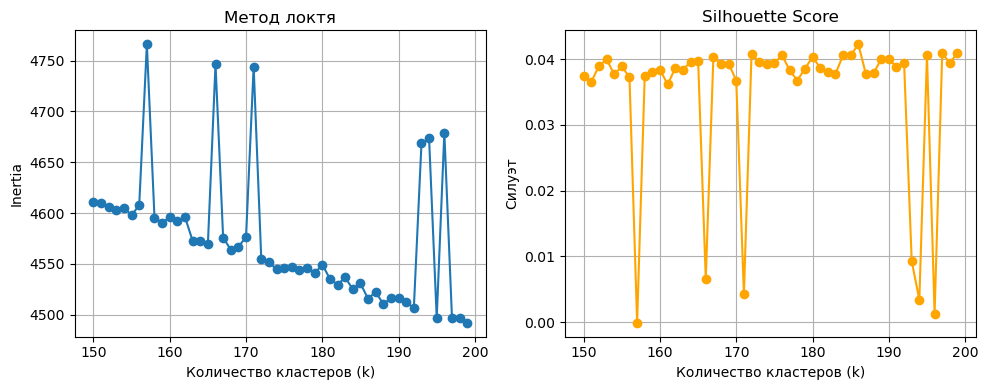

In [10]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
russian_stopwords = stopwords.words("russian")

df = combine_csv_files('./events/2_struct')

# 1️⃣ Очистим текст
df["clean_event"] = df["event"].str.lower()

# 2️⃣ TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words=russian_stopwords
)
X = vectorizer.fit_transform(df["clean_event"])

# 3️⃣ Найдём оптимальное количество кластеров
inertias = []
silhouette_scores = []
K = range(150, 200)  # можно увеличить диапазон

for k in K:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X)
    inertias.append(model.inertia_)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k}: inertia={model.inertia_:.0f}, silhouette={score:.3f}")

# 4️⃣ Визуализация
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'o-')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Inertia")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'o-', color='orange')
plt.title("Silhouette Score")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Силуэт")
plt.grid(True)

plt.tight_layout()
plt.show()
# k=147: inertia=4621, silhouette=0.038
# k=186: inertia=4515, silhouette=0.042

In [11]:
k = 186  # (или то, что покажет график)
model = KMeans(n_clusters=k, random_state=42)
df["cluster"] = model.fit_predict(X)

for i in range(k):
    print(f"\n🟢 Кластер {i}")
    examples = df[df["cluster"] == i]["event"].head(10)
    for e in examples:
        print("  -", e)

# кластеры: фестивали, спорт (чемпионаты мира), вступление на должность (президент, премьер-министр), военные действия, теракты (взрывы), протесты (митинги, демонстрации), космическая тематика, вступление в силу закона, подписание закона, авиакатастрофы, победы на выборах (переизбрания), иннагурации, референдумы, медицина (прорывы), принятие законов, важные визиты, выделение кредита, новости технологий (apple, microsoft, google), объединение территориальных единиц, конференции, саммиты, форумы, установление дипломатических отношений, религиозные события, принятие директивы, присуждение международных наград (кинофестиваль, нобелевские премии), перепись населения,

# Гиперкластеры:
# Негатив (теракты, военные действия, катастрофы, авиакатастровы, крушения, взрывы, землятресения, ураганы, потопы, тафуны, ядерные испытания, столкновения, самосожжение, мятеж, скандалы, пандемии, покушения, казни, массовые отравления,

# todo разделить страны по религиям, по частям света

C:\Users\Ruslan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



🟢 Кластер 0
  - в Алжире (Алжир) прошёл XV Всемирный фестиваль молодёжи и студентов.
  - в Каракасе (Венесуэла) прошёл XVI Всемирный фестиваль молодёжи и студентов.
  - Состоялся международный музыкальный фестиваль live earth с целью привлечения внимания к проблеме глобального потепления.
  - в Душанбе (Таджикистан) состоялся музыкальный фестиваль «Небо Содружества», который объединил молодых эстрадных звёзд из стран СНГ и Грузии.
  - В харькове (украина) открылся 17-й международный музыкальный фестиваль «харьковские ассамблеи»—2010.
  - VII международный фестиваль короткометражного кино и анимации Open Cinema-2011 (Санкт-Петербург, Россия).
  - I международный фестиваль боевых искусств (Астана, Казахстан).
  - XIX Всемирный фестиваль молодёжи и студентов (Сочи, Россия).

🟢 Кластер 1
  - Учёные Великобритании, США и Италии официально объявили о начале опытов по клонированию человека.
  - Парламентские выборы в италии привели к победе крупнейшей итальянской правоцентристской коалиции —